# Stage 1: Create intermediate datasets (CIFAR-10 and CIFAR-100)

**Rui Filipe Martins Monteiro (R20170796) | MSc in Data Science and Advanced Analytics**

<br>

This notebook creates the intermediate datasets for CIFAR-10 and CIFAR-100. This means training a CNN on a dataset, removing the fully-connected layers and producing the (flattened) output from the last convolutional layers. This output is then referred to as the intermediate dataset and saved for future reuse.

The intermediate datasets from this notebook are created imported images. In this case, either CIFAR-10 or CIFAR-100 is used.

<br>

This code is heavily inspired by: Jonathan Janke (https://github.com/novajon/classy-conv-features)

Code changed and improved by: Rui Monteiro

In [1]:
!pip install ann_visualizer

  Created wheel for ann-visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4168 sha256=2c5989515cff2825d5ee6055cec4384e0749dc716a1db8d7e7f0d96ee17752fc
  Stored in directory: /root/.cache/pip/wheels/1b/fc/58/2ab1c3b30350105929308becddda4fb59b1358e54f985e1f4a
Successfully built ann-visualizer


In [2]:
# Imports
import json
import pandas as pd
import numpy as np

import os
import datetime
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, InputLayer, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.initializers import glorot_normal, RandomNormal, Zeros

import math
from tensorflow.keras.datasets import cifar10, cifar100
from scipy.cluster.vq import whiten

import glob

from tensorflow.keras.applications import InceptionV3, Xception, InceptionResNetV2
from tensorflow.keras import Model

from ann_visualizer.visualize import ann_viz

from keras.utils.vis_utils import plot_model

import warnings
warnings.filterwarnings("ignore")

In [3]:
def show_image_classes(images, classes, prefix, suffix=""):
    """Save input images in folder structure and output them

    Parameters
    ----------
    images : array, e.g. numpy array
        images to show

    classes : list
        [not used]

    prefix : string
        prefix to add to output name

    suffix : string
        suffix to add to output name
    """
    for cl in np.unique(y_train):
        for ind, el in enumerate(y_train):
            if el == cl:
                class_pos = ind
                break
        plt.figure()
        plt.imshow(np.uint8(x_train[class_pos]))
        plt.axis('off')
        path = "sample_images/" + prefix + "/"
        if not os.path.exists(path):
            os.makedirs(path)
        plt.savefig(path + input_path.split("/")[1].split("_")[0] + "_" + str(cl) + "_sample_image_" + suffix)

In [4]:
def normalize_production(x, cifar_version):
    """This function is used to normalize instances in production according to saved training set statistics
    (from https://github.com/geifmany/cifar-vgg)

    Parameters
    ----------
    X_train : array, e.g., numpy array
        training data set

    X_test : array, e.g., numpy array
        test data set
    
    cifar_version : string
        the version of CIFAR that's being used - either 'cifar10' or 'cifar100'

    Returns: normalized training set and test set according to preset constants.
    """
    # These values are produced during first training and are general for the standard CIFAR training set normalization
    if cifar_version == 'cifar10':
        mean = 120.707
        std = 64.15
        return (x-mean)/(std+1e-7)

    if cifar_version == 'cifar100':
        mean = 121.936
        std = 68.389
        return (x-mean)/(std+1e-7)

In [5]:
def normalize_data(x_train, x_test, cifar_version):
    """Format the input data by normalizing it

    Parameters
    ----------
    x_train : array, e.g., numpy array
        training data to transform
        
    x_test : array, e.g., numpy array
        test data to transform
        
    cifar_version : string
        the version of CIFAR that's being used - either 'cifar10' or 'cifar100'
    """
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train = normalize_production(x_train, cifar_version)
    x_test = normalize_production(x_test, cifar_version)
    
    return x_train, x_test

In [6]:
def create_CNN_1(input_shape):
    """Create CNN with predefined structure.
    This was manually designed by: Jonathan Janke (from https://github.com/novajon/classy-conv-features)

    Parameters
    ----------
    input_shape : tuple
        shape of the input data
    """
    model = Sequential()

    model.add(Conv2D(128, (3, 3), padding='same',
            input_shape=x_train.shape[1:]))
    model.add(Activation('elu'))

    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('elu'))

    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Activation('elu'))

    model.add(Conv2D(512, (3, 3)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(1024))
    model.add(Activation('elu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    return model

In [33]:
def create_CNN_2(input_shape):
    """Create CNN with predefined structure.
    This was manually designed by: Jonathan Janke (from https://github.com/novajon/classy-conv-features)

    Parameters
    ----------
    input_shape : tuple
        shape of the input data
    """
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    return model

In [8]:
# --- PUT THESE IMPORTS ON TOP OF THE NOTEBOOK ---
from __future__ import print_function
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers


class cifar10vgg:
    """Create VGG-16 model (from https://github.com/geifmany/cifar-vgg)

    Reference:
    - Simonyan, K., & Zisserman, A. (2014). Very Deep Convolutional Networks for Large-Scale Image Recognition.
    """
    def __init__(self,train=True):
        """Initialize VGG-16

        Parameters
        ----------
        train : boolean
            determines if weights should be loaded or retrained
        """
        self.num_classes = 10
        self.weight_decay = 0.0005
        self.x_shape = [32,32,3]

        self.model = self.build_model()
        if train:
            # Train model
            self.model = self.train(self.model)
        else:
            # Location where saved weights are stored
            self.model.load_weights('model_weights_cifarvgg/cifar10vgg.h5')

    def build_model(self):
        """Create CNN with predefined structure
        """
        # Build the network of vgg for 10 classes with massive dropout and weight decay as described in the paper.

        model = Sequential()
        weight_decay = self.weight_decay

        model.add(Conv2D(64, (3, 3), padding='same',
                         input_shape=self.x_shape,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.5))

        model.add(Flatten())
        model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Dropout(0.5))
        model.add(Dense(self.num_classes))
        model.add(Activation('softmax'))
        return model

    def normalize(self,X_train,X_test):
        """This function normalizes inputs for zero mean and unit variance.
        It is used when training a model.

        Parameters
        ----------
        X_train : array, e.g., numpy array
            training data set
        X_test : array, e.g., numpy array
            test data set

        Returns: normalized training set and test set according to the training set statistics.
        """
        mean = np.mean(X_train,axis=(0,1,2,3))
        std = np.std(X_train, axis=(0,1,2,3))
        X_train = (X_train-mean)/(std+1e-7)
        X_test = (X_test-mean)/(std+1e-7)
        return X_train, X_test
    
    def normalize_production(self,x):
        """This function is used to normalize instances in production according to saved training set statistics

        Parameters
        ----------
        X_train : array, e.g., numpy array
            training data set
        X_test : array, e.g., numpy array
            test data set

        Returns: normalized training set and test set according to preset constants.
        """
        # These values produced during first training and are general for the standard CIFAR-10 training set normalization
        mean = 120.707
        std = 64.15
        return (x-mean)/(std+1e-7)

    def predict(self,x,normalize=True,batch_size=50):
        """Makes a prediction using the trained model

        Parameters
        ----------
        X : array, e.g., numpy array
            data to make prediction on
        normalize : boolean
            determines if dataset should be normalized before making a prediction
        batch_size : int
            determines the batch size per prediction batch

        Returns : predictions
        """
        if normalize:
            x = self.normalize_production(x)
        return self.model.predict(x,batch_size)

    def train(self,model):
        """Trains the model

        Parameters
        ----------
        model : Model
            model to be trained
        """
        # Training parameters
        batch_size = 128
        maxepoches = 250
        learning_rate = 0.1
        lr_decay = 1e-6
        lr_drop = 20

        # The data, shuffled and split between train and test sets:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train, x_test = self.normalize(x_train, x_test)

        y_train = keras.utils.to_categorical(y_train, self.num_classes)
        y_test = keras.utils.to_categorical(y_test, self.num_classes)

        def lr_scheduler(epoch):
            return learning_rate * (0.5 ** (epoch // lr_drop))
        reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

        # Data augmentation
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images

        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)

        # Optimization details
        sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

        # Training process in a for loop with learning rate drop every 25 epoches.
        historytemp = model.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            steps_per_epoch=x_train.shape[0] // batch_size,
                            epochs=maxepoches,
                            validation_data=(x_test, y_test),callbacks=[reduce_lr],verbose=2)
        model.save_weights('cifar10vgg.h5')
        return model

In [9]:
def cut_model(input_model):
    """Removes fully-connected layer from the end of a CNN model

    Parameters
    ----------
    input_model : Model
        model to cut
    """
    dense_layer_count = 0
    count = False
    model_length = len(input_model.layers)
    output_model = Sequential()
    output_config = []

    for index in range(model_length):
        if count == True:
            output_config.append(layer.get_config())
            input_model.pop()
        else:
            layer = input_model.layers[index]
        if layer.name.startswith('flatten'):
            count = True
            output_model.add(InputLayer(input_shape=layer.output_shape))          
    # return output_model

In [10]:
def create_output_files(x_train, x_test, y_train, y_test, prefix, suffix = ""):
    """Create the output files to save intermediate datasets for further use

    Parameters
    ----------
    x_train : array, e.g., numpy array
        training input data

    x_test : array, e.g., numpy array
        testing input data

    y_train : list
        training target data

    y_test : list
        test target data

    prefix : string
        prefix to add to output file name

    suffix : string
        suffix to add to output file name
    """
    for i, model in enumerate(models):
        pred_train = model.predict(x_train)
        pred_test = model.predict(x_test)
        pred_train_with_target = np.array([np.array([preds, y_train[i]]) for i, preds in enumerate(pred_train)])
        pred_test_with_target = np.array([np.array([preds, y_test[i]]) for i, preds in enumerate(pred_test)])
        path = input_path + "intermediate/" + prefix + "/" + model_names[i]
        
        if not os.path.exists(path):
            os.makedirs(path)
            
        np.save(path + "/train" + suffix, pred_train_with_target)
        np.save(path + "/test" + suffix, pred_test_with_target)

In [11]:
def plot_model_stats(hist):
    """Plot model statistics after the learning procedure, e.g. accuracy development over time (epochs)

    Parameters
    ----------
    hist : Histogram
        model statistics to plot
    """
    # Summarize history for accuracy
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # Summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## 1. Data Exploration

In [12]:
# Load dataset
cifar_version = 'cifar10'
input_path = "data/cifar10_filtered/"
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [13]:
# cifar_version = 'cifar100'
# input_path = "data/cifar100_filtered/"
# (x_train, y_train), (x_test, y_test) = cifar100.load_data()

In [14]:
num_classes = len(np.unique(y_train))
num_classes

10

In [15]:
print('Shape of x_train is', x_train.shape)
print('Shape of y_train is', y_train.shape)
print()
print('Shape of x_test  is', x_test.shape)
print('Shape of y_test  is', y_test.shape)

Shape of x_train is (50000, 32, 32, 3)
Shape of y_train is (50000, 1)

Shape of x_test  is (10000, 32, 32, 3)
Shape of y_test  is (10000, 1)


In [16]:
treat_data = "normalize"

In [17]:
# Produce a timestamp to attach to future outputs
now = datetime.datetime.now()
prefix = now.strftime("%Y%m%d_%H%M")

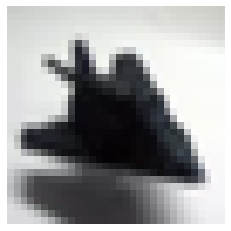

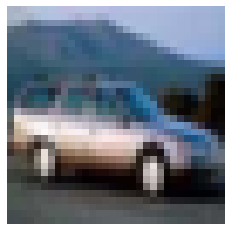

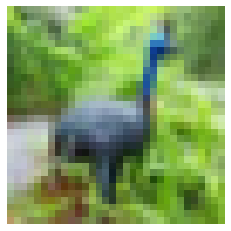

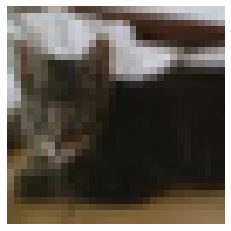

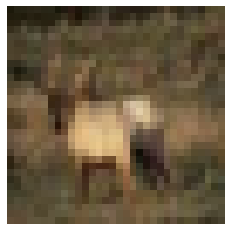

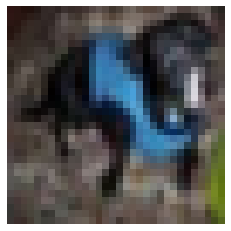

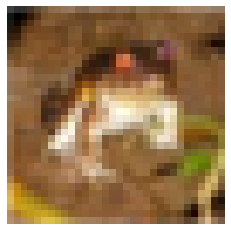

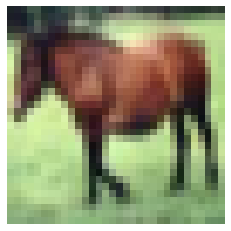

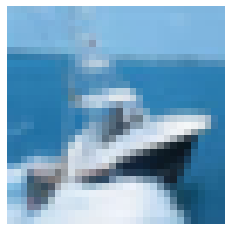

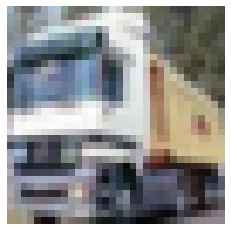

In [18]:
# Show the images to get a visual understanding of the classes
show_image_classes(x_train, y_train, prefix, "raw")

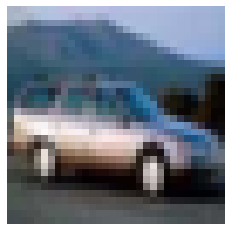

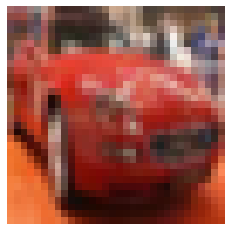

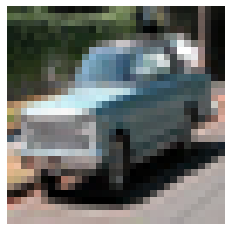

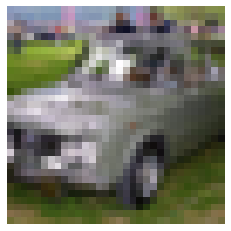

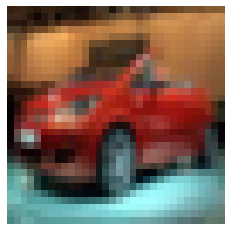

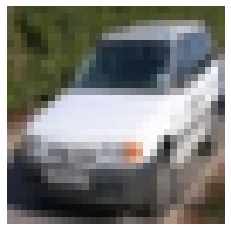

In [19]:
# Check the first "n_images" images of class number "class_n"
n_images = 6
class_n = 0
if cifar_version == 'cifar10':
    class_n = 1

class_n_pos = [ind for ind, el in enumerate(y_train) if el == class_n]

for img in class_n_pos[:n_images]:
    plt.figure()
    plt.imshow(np.uint8(x_train[img]))
    plt.axis('off')

## 2. Data Transformation

In [20]:
# Preprocess data through normalization
# Normalisation of data according to predefined normalize_data method
if treat_data == "normalize":
    x_train, x_test = normalize_data(x_train, x_test, cifar_version=cifar_version)

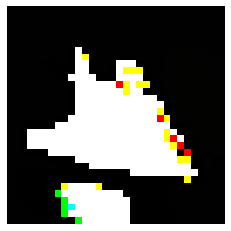

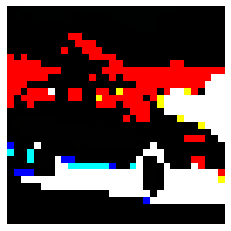

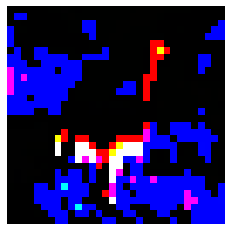

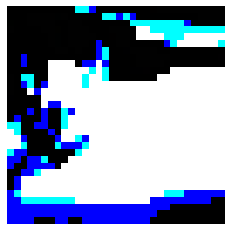

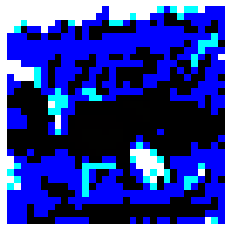

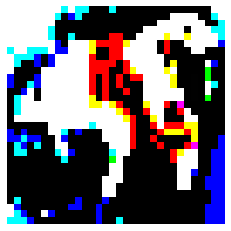

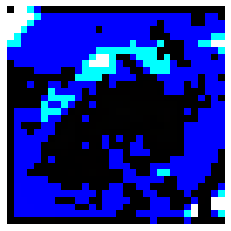

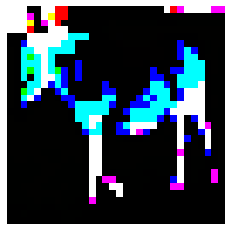

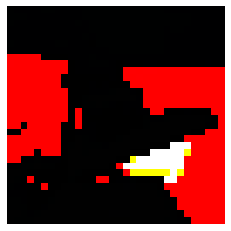

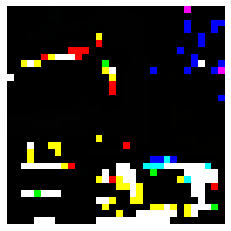

In [21]:
# Show normalized data
if treat_data == "normalize": 
    show_image_classes(x_train, y_train, prefix, "normalized")

In [22]:
# One-hot encoding: make target values categorical
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

## 3. Neural Network Training

In [23]:
datagen = keras.preprocessing.image.ImageDataGenerator(featurewise_center=False, 
                                                       samplewise_center=False, 
                                                       featurewise_std_normalization=False, 
                                                       samplewise_std_normalization=False, 
                                                       zca_whitening=False, 
                                                       zca_epsilon=1e-06, 
                                                       rotation_range=0.0, 
                                                       width_shift_range=0.0, 
                                                       height_shift_range=0.0, 
                                                       brightness_range=None, 
                                                       shear_range=0.0, 
                                                       zoom_range=0.0, 
                                                       channel_shift_range=0.0, 
                                                       fill_mode='nearest', 
                                                       cval=0.0, 
                                                       horizontal_flip=False, 
                                                       vertical_flip=False, 
                                                       rescale=None, 
                                                       preprocessing_function=None, 
                                                       data_format=None, 
                                                       validation_split=0.0)

In [24]:
# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_train)

In [25]:
models = []
model_names = []
input_shape = x_train[0].shape
batch_size = 100
epochs = 80

In [26]:
# Create neural network models
models.append(create_CNN_1(input_shape))
model_names.append("CNN_Input_1")

In [34]:
models.append(create_CNN_2(input_shape))
model_names.append("CNN_Input_2")

In [37]:
history = []
lr = 0.0001

for model in models:
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(lr=lr),
                  metrics=['accuracy'])

In [38]:
path = os.getcwd() + '/models/h5files/'

if not os.path.exists(path):
    os.makedirs(path)

# Fit neural network models to training data
for model_ind, model in enumerate(models):  
    history.append(
      model.fit_generator(
          datagen.flow(x_train, y_train_categorical, batch_size=batch_size),
          steps_per_epoch=len(x_train)/batch_size,
          epochs=epochs,
          verbose=1,
          validation_data = (x_test, y_test_categorical)))
    
    model.save_weights(path + prefix + '_' + model_names[model_ind] + ".h5")
    
    print ("Model success")

Epoch 1/80
500/500 [==============================] - 67s 111ms/step - loss: 1.5084 - accuracy: 0.4584 - val_loss: 1.1864 - val_accuracy: 0.5819
Epoch 2/80
500/500 [==============================] - 55s 109ms/step - loss: 1.1372 - accuracy: 0.6044 - val_loss: 0.9789 - val_accuracy: 0.6575
Epoch 3/80
500/500 [==============================] - 55s 110ms/step - loss: 0.9993 - accuracy: 0.6538 - val_loss: 0.9262 - val_accuracy: 0.6785
Epoch 4/80
500/500 [==============================] - 54s 108ms/step - loss: 0.9178 - accuracy: 0.6810 - val_loss: 0.8299 - val_accuracy: 0.7141
Epoch 5/80
500/500 [==============================] - 55s 110ms/step - loss: 0.8525 - accuracy: 0.7053 - val_loss: 0.7903 - val_accuracy: 0.7241
Epoch 6/80
500/500 [==============================] - 54s 108ms/step - loss: 0.7993 - accuracy: 0.7231 - val_loss: 0.7547 - val_accuracy: 0.7390
Epoch 7/80
500/500 [==============================] - 55s 110ms/step - loss: 0.7494 - accuracy: 0.7399 - val_loss: 0.7452 - val_ac

In [39]:
# Print the number of model parameters
for model in models:
    print(f'{model_names[models.index(model)]} # of Parameters:', model.count_params())
    print('\n')

CNN_Input_1 # of Parameters: 6684810


CNN_Input_2 # of Parameters: 1250858




In [40]:
# Print the absolute error
for model in models:
    # The absolute error is X, thus the accuracy is 1-X
    predicted_x = model.predict(x_test)
    residuals = np.argmax(predicted_x, 1)!=np.argmax(y_test_categorical, 1)

    loss = sum(residuals)/len(residuals)
    print(f'{model_names[models.index(model)]} Absolute Error:', round(loss, 3))
    print('\n')

CNN_Input_1 Absolute Error: 0.18


CNN_Input_2 Absolute Error: 0.201




In [41]:
# Get metrics for models on unseen data
for model in models:
    score = model.evaluate(x_test, y_test_categorical, verbose=0)
    print(f'{model_names[models.index(model)]} Test loss:', round(score[0], 3))
    print(f'{model_names[models.index(model)]} Test accuracy:', round(score[1], 3))
    print('\n')

CNN_Input_1 Test loss: 1.081
CNN_Input_1 Test accuracy: 0.82


CNN_Input_2 Test loss: 0.665
CNN_Input_2 Test accuracy: 0.799




In [42]:
path = os.getcwd() + '/models/viz/'

if not os.path.exists(path):
    os.makedirs(path)

# Visualize the CNN model architectures
for i, model in enumerate(models):
    plot_model(model, 
               path + prefix + '_' + model_names[i] + '.png', 
               show_shapes=True)
    
    ann_viz(model, 
            filename=path + prefix + '_' + model_names[i] + '.gv', 
            title='Visualisation of ' + model_names[i])

In [43]:
# Summarize models
for i, model in enumerate(models):
    model.summary()
    print('\n'*2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 activation (Activation)     (None, 32, 32, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 128)       147584    
                                                                 
 activation_1 (Activation)   (None, 30, 30, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 128)       0         
                                                        

### 3.1. VGG-16 Intermediate Dataset

In [ ]:
# Upload h5 files with VGG-16's weights and unzip
!unzip model_weights_cifarvgg.zip

Archive:  model_weights_cifarvgg.zip
  inflating: model_weights_cifarvgg/cifar100vgg.h5  
  inflating: model_weights_cifarvgg/cifar10vgg.h5  


In [ ]:
# Remove zip file with the weights
!rm model_weights_cifarvgg.zip

In [ ]:
# The weights for VGG-16 trained on CIFAR are available online
# Therefore, this model does not need to be retrained
# The pretrained weights can be found on https://github.com/geifmany/cifar-vgg
vgg_16 = cifar10vgg(train=False)

In [ ]:
print('VGG-16 # of Parameters:', vgg_16.model.count_params())

VGG-16 # of Parameters: 15001418


In [ ]:
# The absolute error is X, thus the accuracy is 1-X
predicted_x = vgg_16.predict(x_test, normalize=False)
residuals = np.argmax(predicted_x, 1)!=np.argmax(y_test_categorical, 1)

loss = sum(residuals)/len(residuals)
print('VGG-16 Absolute Error:', round(loss, 3))
# An absolute error of 0.064 represents an accuracy of 0.936

VGG-16 Validation 0/1 loss: 0.064


In [ ]:
# Add VGG-16 to model list
models.append(keras.models.clone_model(vgg_16.model))
model_names.append('VGG_16')
models[model_names.index('VGG_16')].set_weights(vgg_16.model.get_weights())

In [ ]:
# # Visualize VGG-16 model architectures
# ann_viz(vgg_16.model, 
#         filename=path + prefix + '_VGG_16.gv',
#         title='Visualization of VGG-16')

In [ ]:
# Summarize VGG-16 model
vgg_16.model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 activation_8 (Activation)   (None, 32, 32, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 activation_9 (Activation)   (None, 32, 32, 64)        0         
                                                      

## 4. Remove the Fully-connected layers

In [44]:
# Cut the models to remove everything after the flattening layer (remove fully-connected layers)
# output_models = []
for model in models:
    cut_model(model)
    # output_models.append(out)

In [45]:
# Create output files
now = datetime.datetime.now()
prefix = now.strftime("%Y%m%d_%H%M")
create_output_files(x_train, 
                    x_test, 
                    y_train, 
                    y_test, 
                    prefix, 
                    suffix = "_" + treat_data)

Model: CNN_Input_1


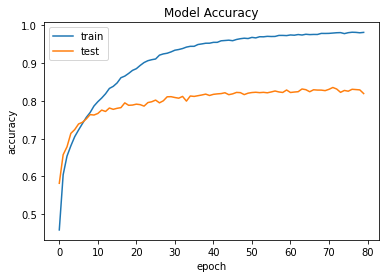

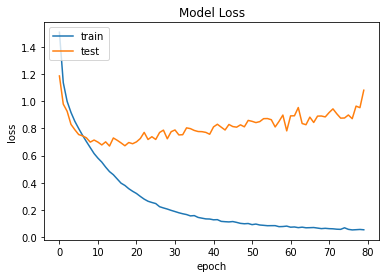

In [46]:
# Plot history of model training
index = 0
print(f'Model: {model_names[index]}')

plot_model_stats(history[index])

Model: CNN_Input_2


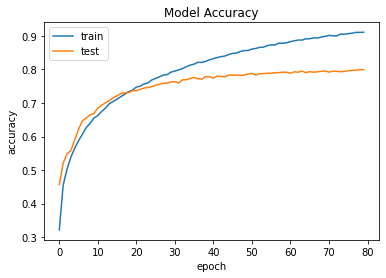

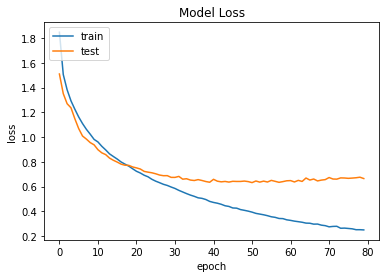

In [47]:
index = 1
print(f'Model: {model_names[index]}')

plot_model_stats(history[index])

In [48]:
!zip -r /content/file.zip /content

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 24%)
  adding: content/.config/.metricsUUID (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2022.02.18/ (stored 0%)
  adding: content/.config/logs/2022.02.18/14.33.21.113721.log (deflated 54%)
  adding: content/.config/logs/2022.02.18/14.33.12.888636.log (deflated 86%)
  adding: content/.config/logs/2022.02.18/14.32.54.268036.log (deflated 53%)
  adding: content/.config/logs/2022.02.18/14.32.33.591601.log (deflated 90%)
  adding: content/.config/logs/2022.02.18/14.33.40.493787.log (deflated 54%)
  adding: content/.config/logs/2022.02.18/14.33.41.267515.log (deflated 53%)
  adding: con

In [ ]:
# After this is finished: delete this notebook from GitHub -> 1_a_gp_approach_for_cv.ipynb